In [1]:
!git clone https://github.com/m0chi1216/hlab2023-nlp100.git

fatal: destination path 'hlab2023-nlp100' already exists and is not an empty directory.


In [2]:
cd hlab2023-nlp100

c:\Users\rio_m\OneDrive - 国立大学法人東海国立大学機構\100knock\hlab2023-nlp100\hlab2023-nlp100


In [3]:
!git checkout -b suzuki origin/suzuki

fatal: a branch named 'suzuki' already exists


In [4]:
cd c:\Users\rio_m\OneDrive - 国立大学法人東海国立大学機構\100knock\hlab2023-nlp100

c:\Users\rio_m\OneDrive - 国立大学法人東海国立大学機構\100knock\hlab2023-nlp100


In [5]:
with open("readme.txt","r")as fp:
  words=fp.read()
  print(words)
  fp.close()

SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected from an online aggregator in the period from March 10 to August 10 of 2014. The resources are grouped into clusters that represent pages discussing the same news story. The dataset includes also references to web pages that point (has a link to) one of the news page in the collection.

TAGS: web pages, news, aggregator, classification, clustering

LICENSE: Public domain - Due to restrictions on content and use of the news sources, the corpus is limited to web references (urls) to web pages and does not include any text content. The references have been retrieved from the news aggregator through traditional web browsers. 

FILE ENCODING: UTF-8

FORMAT: Tab delimited CSV files. 

DATA SHAPE AND STATS: 422937 news pages and divided up into:

152746 	news of business category
108465 	news of science and technology category
115920 	news of business category
 45615 	news of

In [6]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install scikit-learn 

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./newsCorpora.csv',header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df=df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']),['TITLE', 'CATEGORY']]

train,valid=train_test_split(df,test_size=0.2,random_state=1,shuffle=True,stratify=df["CATEGORY"])
valid,test=train_test_split(valid,test_size=0.5,random_state=1,shuffle=True,stratify=valid["CATEGORY"])

train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64
検証データ
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64
評価データ
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64


In [9]:
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換

  return text

In [10]:
df=pd.concat([train,valid,test])
df.reset_index(drop=True,inplace=True)
df["TITLE"]=df["TITLE"].map(lambda x:preprocessing(x))
print(df.head())

                                               TITLE CATEGORY
0  corrected update 0 brent crude falls again as ...        b
1  corrected retailer michaels stores confirms pa...        b
2  britney spears hits her local supermarket dres...        e
3  orders propel us service industries as sales i...        b
4  column fed to widen main st wall st gap  james...        b


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

vec_tfidf=TfidfVectorizer(min_df=30)
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE']) 
X_test = vec_tfidf.transform(test['TITLE'])

X_train_valid = pd.DataFrame(X_train_valid.toarray(),columns=vec_tfidf.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names_out())

X_train=X_train_valid[:len(train)]
X_valid=X_train_valid[len(train):]

print(X_train.head())


   0th  about  above  action  actor  adds  affirms  africa     after    again  \
0  0.0    0.0    0.0     0.0    0.0   0.0      0.0     0.0  0.000000  0.33371   
1  0.0    0.0    0.0     0.0    0.0   0.0      0.0     0.0  0.000000  0.00000   
2  0.0    0.0    0.0     0.0    0.0   0.0      0.0     0.0  0.425078  0.00000   
3  0.0    0.0    0.0     0.0    0.0   0.0      0.0     0.0  0.000000  0.00000   
4  0.0    0.0    0.0     0.0    0.0   0.0      0.0     0.0  0.000000  0.00000   

   ...  yellen  yen  yet  yields  york  you  young  your  zac  zone  
0  ...     0.0  0.0  0.0     0.0   0.0  0.0    0.0   0.0  0.0   0.0  
1  ...     0.0  0.0  0.0     0.0   0.0  0.0    0.0   0.0  0.0   0.0  
2  ...     0.0  0.0  0.0     0.0   0.0  0.0    0.0   0.0  0.0   0.0  
3  ...     0.0  0.0  0.0     0.0   0.0  0.0    0.0   0.0  0.0   0.0  
4  ...     0.0  0.0  0.0     0.0   0.0  0.0    0.0   0.0  0.0   0.0  

[5 rows x 682 columns]


In [12]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=123)

In [13]:
import numpy as np
def score(lg,x):
  return[np.max(lg.predict_proba(x),axis=1),lg.predict(x)]

In [14]:
train_predict=score(lg,X_train)
test_predict=score(lg,X_test)
print(train_predict)

[array([0.94465832, 0.53412461, 0.74239951, ..., 0.96803602, 0.66861914,
       0.92907688]), array(['b', 'b', 'e', ..., 'b', 'b', 'b'], dtype=object)]


In [15]:
from sklearn.metrics import accuracy_score

train_accuracy=accuracy_score(train["CATEGORY"],train_predict[1])
test_accuracy=accuracy_score(test["CATEGORY"],test_predict[1])

print(f"学習データの正解率={train_accuracy:.3f}")
print(f"テストデータの正解率={test_accuracy:.3f}")

学習データの正解率=0.868
テストデータの正解率=0.827


In [16]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


[[4149  253   19   81]
 [ 154 4031   16   22]
 [ 120  204  387   17]
 [ 260  250   18  691]]


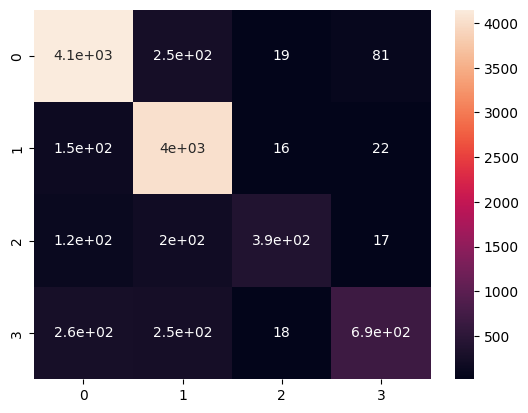

In [18]:
train_confusion=confusion_matrix(train["CATEGORY"],train_predict[1])
print(train_confusion)
sns.heatmap(train_confusion,annot=True)
plt.show()

[[501  37   4  20]
 [ 23 494   3   8]
 [ 15  37  34   5]
 [ 41  35   3  74]]


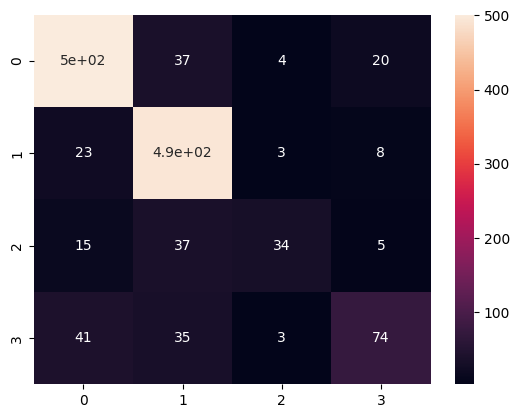

In [19]:
test_confusion=confusion_matrix(test["CATEGORY"],test_predict[1])
print(test_confusion)
sns.heatmap(test_confusion,annot=True)
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate(answer,predict):
    precision=precision_score(answer,predict,average=None,labels=['b', 'e', 't', 'm'])
    precision=np.append(precision,precision_score(answer,predict,average="micro"))
    precision=np.append(precision,precision_score(answer,predict,average="macro"))

    recall=recall_score(answer,predict,average=None,labels=['b', 'e', 't', 'm'])
    recall=np.append(recall,recall_score(answer,predict,average="micro"))
    recall=np.append(recall,recall_score(answer,predict,average="macro"))

    f1=f1_score(answer,predict,average=None,labels=['b', 'e', 't', 'm'])
    f1=np.append(f1,f1_score(answer,predict,average="micro"))
    f1=np.append(f1,f1_score(answer,predict,average="macro"))

    scores=pd.DataFrame({"適合率": precision,"再現率": recall,"F1スコア": f1},index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])                    
    return scores

print(calculate(test["CATEGORY"],test_predict[1]))

             適合率       再現率     F1スコア
b       0.863793  0.891459  0.877408
e       0.819237  0.935606  0.873563
t       0.691589  0.483660  0.569231
m       0.772727  0.373626  0.503704
マイクロ平均  0.826837  0.826837  0.826837
マクロ平均   0.786837  0.671088  0.705976


In [21]:
from sklearn.metrics import classification_report

print(classification_report(test['CATEGORY'], test_predict[1], labels=['b', 'e', 'm', 't']))

              precision    recall  f1-score   support

           b       0.86      0.89      0.88       562
           e       0.82      0.94      0.87       528
           m       0.77      0.37      0.50        91
           t       0.69      0.48      0.57       153

    accuracy                           0.83      1334
   macro avg       0.79      0.67      0.71      1334
weighted avg       0.82      0.83      0.82      1334



In [22]:
feature_names = X_train.columns.values

for i in range(len(lg.classes_)):
    coef=lg.coef_[i]
    features=[(feature_names[j],np.abs(coef[j])) for j in range(len(feature_names))]
    print(lg.classes_[i])
    best=sorted(features,key=lambda x:x[1],reverse=True)
    worst=sorted(features,key=lambda x:x[1],reverse=False)
    print("best")
    for i in range(10):
        print(best[i])
    print("worst")
    for i in range(10):
        print(worst[i])


b
best
('bank', 3.520338060619401)
('stocks', 3.3230982703016556)
('fed', 3.186135387461966)
('ecb', 3.1110467002835485)
('china', 2.91248404139848)
('oil', 2.7667692372002617)
('euro', 2.731408903147505)
('ukraine', 2.6028433801141366)
('dollar', 2.6005727019336717)
('obamacare', 2.5582205374427724)
worst
('last', 0.0014772112188540043)
('late', 0.0021761067334205306)
('do', 0.0022480434661783255)
('case', 0.0029052349199880896)
('beats', 0.00637935259684704)
('second', 0.008131991784760852)
('news', 0.009688984491575976)
('to', 0.010446700912796274)
('another', 0.013242195031976314)
('all', 0.014933846173449741)
e
best
('kardashian', 2.937065409941254)
('google', 2.866332140258023)
('chris', 2.772537821237053)
('china', 2.4708005609483883)
('movie', 2.4646437043497227)
('update', 2.4451006351585822)
('film', 2.443813367861445)
('thrones', 2.411793166358106)
('data', 2.4102580087097167)
('fans', 2.324650109796834)
worst
('week', 0.0006689304320942949)
('three', 0.0015646110639395015)


In [23]:
from tqdm import tqdm

result=[]
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
    lg=LogisticRegression(random_state=123,max_iter=10000,C=C)
    lg.fit(X_train,train["CATEGORY"])

    train_predict=score(lg,X_train)
    valid_predict=score(lg,X_valid)
    test_predict=score(lg,X_test)

    train_accuracy=accuracy_score(train["CATEGORY"],train_predict[1])
    valid_accuracy=accuracy_score(valid["CATEGORY"],valid_predict[1])
    test_accuracy=accuracy_score(test["CATEGORY"],test_predict[1])
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


In [24]:
print(result)

[[1e-05, 0.42185157421289354, 0.42203898050974514, 0.42128935532233885], [0.0001, 0.42185157421289354, 0.42203898050974514, 0.42128935532233885], [0.001, 0.5668103448275862, 0.5667166416791605, 0.5599700149925038], [0.01, 0.7440967016491754, 0.7353823088455772, 0.7368815592203898], [0.1, 0.8061281859070465, 0.7886056971514243, 0.7818590704647677], [1.0, 0.867503748125937, 0.8403298350824587, 0.8268365817091454], [10.0, 0.8856821589205397, 0.841079460269865, 0.8178410794602698], [100.0, 0.8872751124437781, 0.8328335832083958, 0.8088455772113943], [1000.0, 0.8867128935532234, 0.8335832083958021, 0.8095952023988006], [10000.0, 0.8868065967016492, 0.8335832083958021, 0.8095952023988006]]


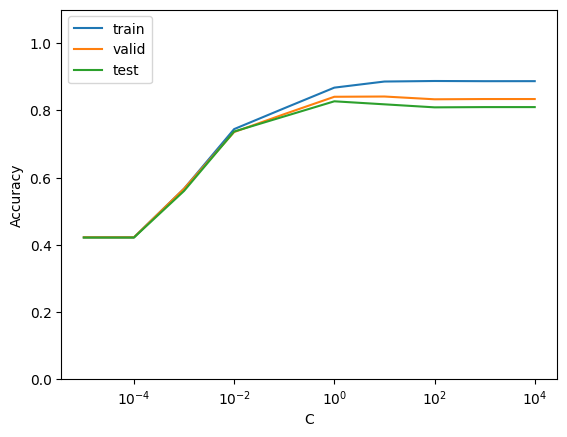

In [25]:
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()